In [122]:
import sys
sys.path.insert(0, "../")
import os
import random
import json
import numpy
import pandas
import torch
import seaborn
import matplotlib
from IPython.display import Audio
from matplotlib import pyplot
from tqdm.notebook import tqdm
from dataloaders.image_caption_dataset import ImageCaptionDataset
from captum import attr
from pytorch_lightning.utilities.seed import seed_everything
from speech2image.model import Speech2Image

In [2]:
proj = "../"
data_path = "../data/hval.json"
model_path = "../checkpoints_speech2image/stylegan2-050721_2039/speech2image_epoch=0887.ckpt"

In [3]:
test_set = ImageCaptionDataset(data_path, audio_conf={"audio_type": "audio"})
test_set.image_base_path = os.path.join(proj, test_set.image_base_path)
test_set.audio_base_path = os.path.join(proj, test_set.audio_base_path)

In [31]:
z_constant = torch.randn(1, 1, 512).cuda()

In [76]:
class SimpleModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.enc = model.enc
        self.G_EMA = model.G_EMA
    
    def forward(self, x, n):
        x = self.enc(x)
        z = x.mean(dim=1).view(1, x.shape[0], -1)
        z = torch.cat([z, n], dim=0).unbind(0)
        torch.manual_seed(0)
        return self.G_EMA(z, randomize_noise=False)[0]

In [78]:
model = Speech2Image().cuda()
if model_path:
    model.load_state_dict(torch.load(model_path, map_location=model.device)["state_dict"], strict=False)

model = SimpleModel(model)

In [93]:
ig = attr.Saliency(model)

In [ ]:
n = numpy.random.randint(20)
for i, (_, audio, _, apath) in enumerate(test_set):
    if i == n:
        break

Global seed set to 0


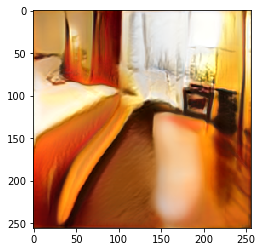

In [80]:
seed_everything(0)
img = model(audio.unsqueeze(0), z_constant)
img_array = img[0].permute(1, 2, 0).detach().cpu().numpy()
pyplot.imshow(img_array)

In [94]:
d = {}
s = 4
for c in tqdm(range(3)):
    for x in tqdm(range(0, 256, 256//s), leave=False):
        for y in tqdm(range(0, 256, 256//s), leave=False):
            seed_everything(0)
            d[(c, x, y)] = ig.attribute(audio.unsqueeze(0), [(c, x, y)], additional_forward_args=z_constant)

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


In [97]:
d_allchannels = {}
for (c, x, y), v in d.items():
    d_allchannels.setdefault((x, y), torch.zeros_like(v))
    d_allchannels[(x, y)] += v

d_allchannels = {k:v/3 for k, v in d_allchannels.items()}

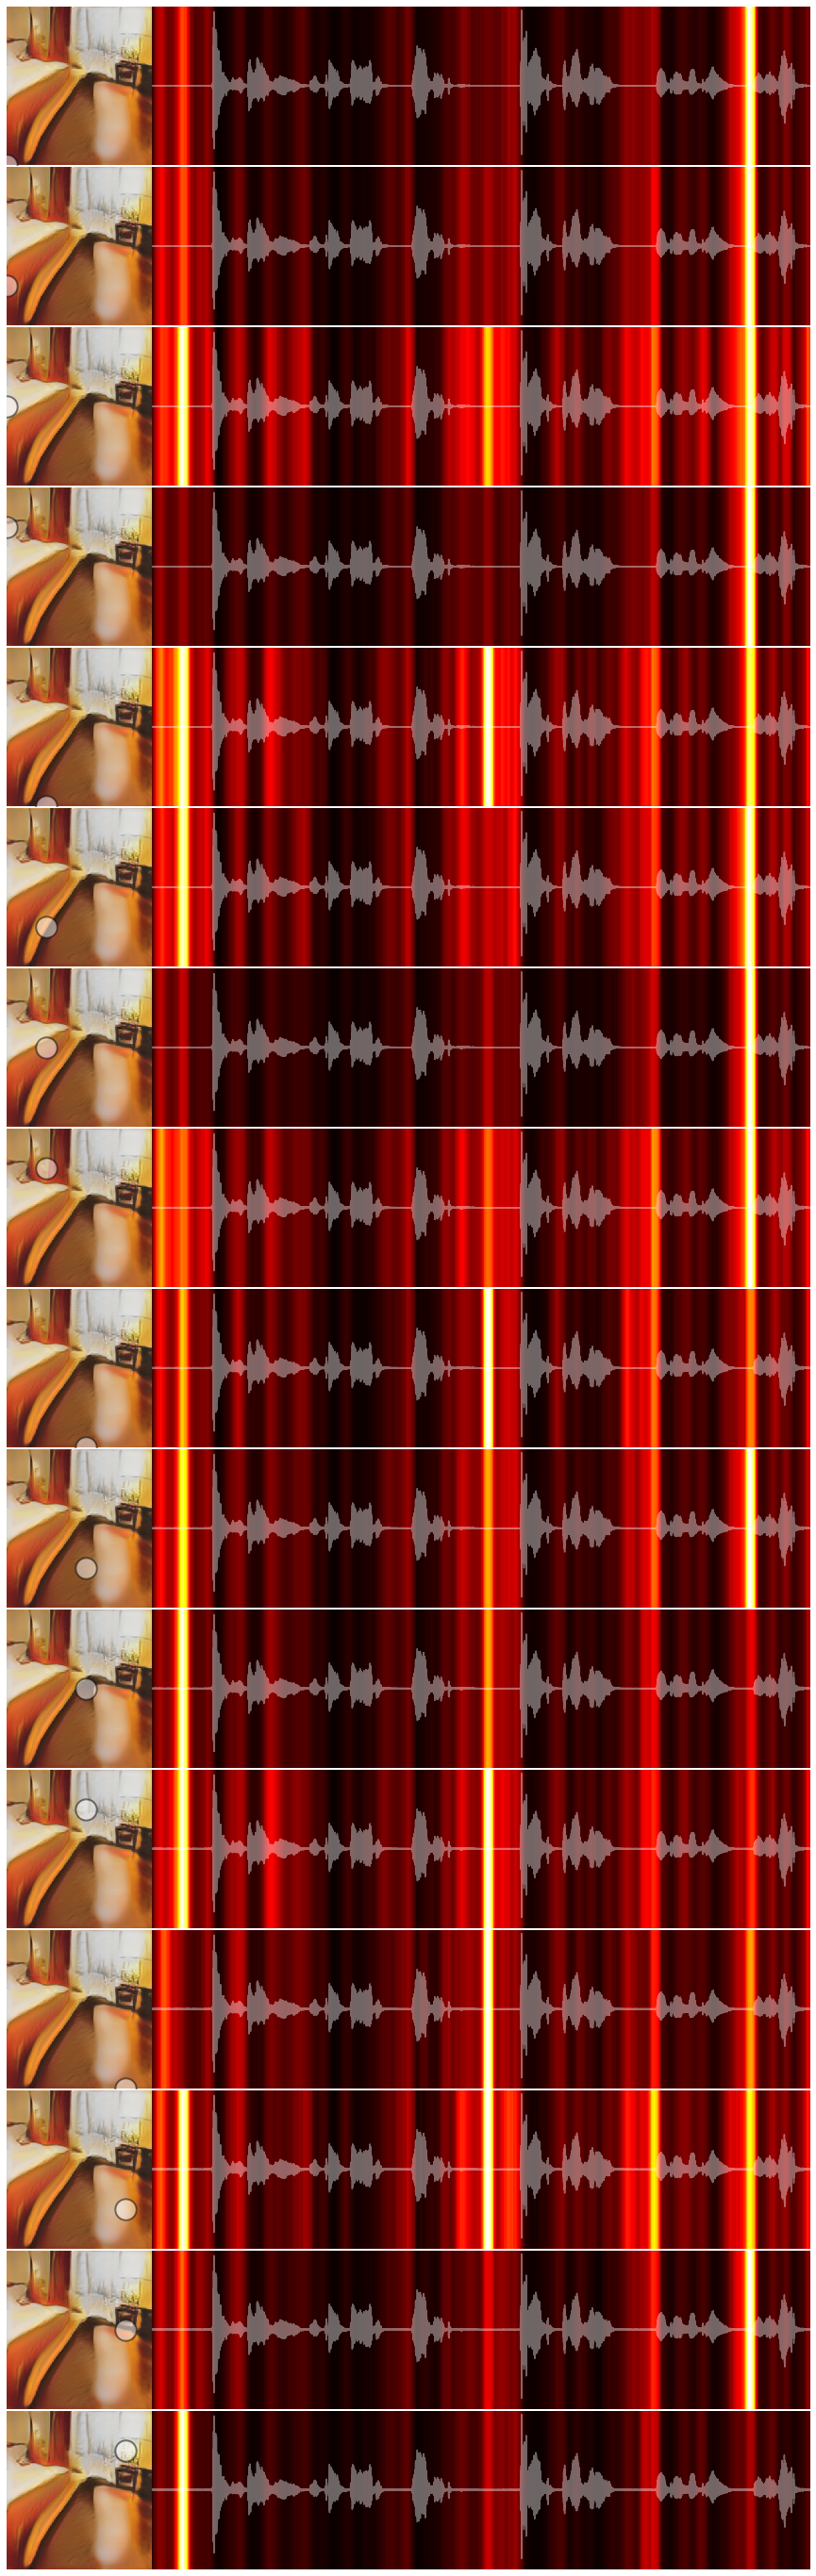

In [120]:
fig, ax = pyplot.subplots(nrows=16, ncols=2, figsize=(20, 50))
fig.subplots_adjust(hspace=0.01, wspace=-0.4)
for i, a in enumerate(ax[:, 0]):
    img_arr = img_array[::-1, :]
    a.imshow((img_arr - img_arr.min())/(img_arr.max() - img_arr.min()))
    a.scatter(x=[(i//s) * (256//s)], y=[(i % s) * (256//s)], s=500, c="w", linewidth=2, edgecolor="k", alpha=0.5)
    a.set_xlim(0, 256)
    a.set_ylim(0, 256)
    a.set_axis_off()

for i, a in enumerate(ax[:, 1]):
    kernel_size = 2000
    kernel = numpy.ones(kernel_size)/kernel_size
    y = d_allchannels[((i//s) * (256//s), (i % s) * (256//s))].detach().cpu().numpy()[0]
    y = numpy.convolve(y, kernel, mode="same")
    audio_info = audio.cpu().numpy()
    l = numpy.where(audio_info > 0.001)[0].max()
    a.plot(audio_info[:l], color="w", alpha=0.4)
    a.imshow(y[None, :l], cmap="hot", aspect="auto")
    a.set_axis_off()

In [123]:
Audio(apath)

In [104]:
import gc
ig = None
torch.cuda.empty_cache()
gc.collect()

50